#Libraries Used

In [ ]:
import pandas as pd
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer

#Mount GOOGLE DRIVE

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/test_and_train.csv'

df = pd.read_csv(file_path)

Mounted at /content/drive


<ipython-input-3-1de116531417>:6: DtypeWarning: Columns (50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


#Creating a copy of orignal dataframe

In [ ]:
df_original = df.copy()

#Converting date column in 'datetime' object

In [ ]:
df['meeting_date'] = pd.to_datetime(df['meeting_date'])

# Sort the DataFrame by the 'date' column in ascending order
df_sorted = df.sort_values(by='meeting_date')
print(df_sorted)

       meeting_date  course_id  Unnamed: 0  race_number  horse_code  \
176050   2014-02-11         47           0            3      312037   
176047   2014-02-11         47           0            6      360458   
176046   2014-02-11          2           0            4      321870   
176045   2014-02-11          2           0            2      351605   
176044   2014-02-11          2           0            5      224734   
...             ...        ...         ...          ...         ...   
175923   2021-11-15         40           0            5      514475   
175922   2021-11-15         29           0            6      471914   
175921   2021-11-15         29           0            5      557760   
175929   2021-11-15         40           0            6      496189   
175983   2021-11-15         29           0            1      558279   

       course_name country_code            horse_name  horse_age horse_gender  \
176050   SOUTHWELL          GBR        ARABIAN FLIGHT          5  

#Dealing with the missing values of the Dataset


In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

equipment_char                             591901
horses_for_course_neg                         122
pre_race_master_symbol                     700788
jockey_uplift                                 122
trainer_uplift                                122
                                            ...  
hrs_best_last_10_mordin_speed_rank         112858
hrs_best_all_mordin_speed_rank             112858
hrs_best_all_mordin_speed_going            112858
hrs_best_last_3_mordin_speed_going         112858
hrs_best_last_3_mordin_speed_rank_going    112858
Length: 77, dtype: int64


In [ ]:
# Calculate the threshold for 30% missing values
threshold = len(df) * 0.3
# Drop columns where the number of missing values exceeds the threshold, excluding 'position_official'
columns_to_drop = df.columns[(df.isnull().sum() > threshold) & (df.columns != 'position_official')]
df = df.drop(columns=columns_to_drop)

# For numerical columns, use mean imputation
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# For categorical columns, use the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
# Display the columns that were dropped and the new shape of the dataframe
print("Dropped Columns:", list(columns_to_drop))
print("New DataFrame Shape:", df.shape)

Dropped Columns: ['equipment_char', 'pre_race_master_symbol', 'form_figures', 'crs_dis_win_fav_text', 'hrs_best_fp_7to12', 'hrs_total_class_wins', 'hrs_days_since_incident']
New DataFrame Shape: (922755, 243)


# Filter out races with less than 5 or more than 20 horses


In [ ]:
# Print the sorted DataFrame
print(df)

# Filter out races with less than 5 or more than 20 horses
df = df[(df['number_of_runners'] >= 5) & (df['number_of_runners'] <= 20)]

# Group by race id and count the number of winners
winners_per_race = df[df['win'] == 1].groupby('race_id').size()

# Identify races with more than one winner
races_with_multiple_winners = winners_per_race[winners_per_race > 1].index

# Filter out races with multiple winners
df = df[~df['race_id'].isin(races_with_multiple_winners)]

# Print the columns that were dropped and the new shape of the DataFrame
print("Dropped Columns: ['races with less than 5 or more than 20 horses', 'races with multiple winners']")
print("New DataFrame Shape:", df.shape)

       meeting_date  course_id  Unnamed: 0  race_number  horse_code  \
176050   2014-02-11       47.0         0.0          3.0    312037.0   
176047   2014-02-11       47.0         0.0          6.0    360458.0   
176046   2014-02-11        2.0         0.0          4.0    321870.0   
176045   2014-02-11        2.0         0.0          2.0    351605.0   
176044   2014-02-11        2.0         0.0          5.0    224734.0   
...             ...        ...         ...          ...         ...   
175923   2021-11-15       40.0         0.0          5.0    514475.0   
175922   2021-11-15       29.0         0.0          6.0    471914.0   
175921   2021-11-15       29.0         0.0          5.0    557760.0   
175929   2021-11-15       40.0         0.0          6.0    496189.0   
175983   2021-11-15       29.0         0.0          1.0    558279.0   

       course_name country_code            horse_name  horse_age horse_gender  \
176050   SOUTHWELL          GBR        ARABIAN FLIGHT        5.0  

#Defining Pre-Race features and developing a correaltion matrix




In [ ]:
# Define the list of pre-race features to keep
pre_race_features = [
    'meeting_date', 'course_id', 'race_number', 'horse_code', 'course_name', 'country_code', 'horse_name', 'horse_age',
    'horse_gender', 'draw', 'weight_carried', 'jockey_name', 'jockey_code', 'apprentice_claim', 'trainer_name',
    'trainer_code', 'owner_name', 'owner_code', 'equipment', 'equipment_char', 'handicap_mark', 'long_handicap',
    'horses_for_course_neg', 'horses_for_course_pos', 'pre_race_adjusted_rating', 'pre_race_master_rating',
    'pre_race_epf', 'pre_race_master_symbol', 'horse_in_focus', 'warning_horse', 'jockey_uplift', 'trainer_uplift',
    'hot_trainer', 'cold_trainer', 'sectional_flag', 'top_rated', 'equipment_first_time', 'wind_op',
    'scheduled_time_gmt', 'scheduled_time_bst', 'actual_race_time_local', 'surface_type', 'race_type', 'distance_furlong',
    'race_title', 'going', 'going_abbrev', 'number_of_runners', 'number_of_places', 'race_code', 'prize_fund',
    'pre_race_review', 'race_class', 'bf_market_id', 'distance_type', 'race_id', 'saddle_cloth', 'significant_improver',
    'jockey_in_form', 'form_figures', 'entry_number', 'bha_rating', 'crs_dis_win_fav_text', 'days_off', 'bf_selection_id',
    'last_run_flat', 'last_run_jump', 'wins_at_course', 'wins_at_distance', 'wins_at_course_distance', 'penalty',
    'first_time_tongue_tie', 'trainer_off_break', 'trainer_first_time_equipment', 'trainer_handicap_debutants',
    'sire_cd', 'sire_going', 'novice', 'juvenile', 'hunter_chase', 'stakes', 'maiden', 'amateur', 'apprentice',
    'listed', 'handicap', 'race_type_v2', 'age_bin', 'long_hcap_bin', 'max_age_value', 'month', 'year', 'w_day',
    'week_no', 'win', 'distance_yards', 'dst_grps', 'hrs_career_races', 'hrs_lto_bsp_win_rank', 'hrs_days_off',
    'hrs_days_off_bin', 'hrs_last_2_form', 'hrs_first_run', 'hrs_lto_unfin', 'hrs_lto_unfin_fr', 'hrs_lto_unfin_fin',
    'hrs_lto_unfin_dnf', 'hrs_lto_race_type', 'hrs_race_type_delta', 'hrs_crs_win', 'hrs_dst_win', 'hrs_crs_dst_win',
    'hrs_crs_dst_nov_win', 'hrs_crs_dst_hcap_win', 'hrs_lto_in_the_money', 'hrs_lto_close_fp', 'hrs_lto_good_race',
    'hrs_consistency', 'hrs_consistency_bin', 'hrs_consistency_bin_100', 'hrs_consistency_bin_60',
    'hrs_consistency_bin_30', 'hrs_consistency_bin_10', 'hrs_consistency_bin_70', 'hrs_consistency_bin_80',
    'hrs_consistency_bin_90', 'hrs_days_since_good_race', 'hrs_has_going_wins', 'hrs_lto_winning_margin',
    'hrs_lto_winning_margin_lost', 'hrs_lto_winning_margin_close_fin', 'hrs_lto_winning_margin_good_fin',
    'hrs_prms_blank', 'hrs_prms_small_p', 'hrs_prms_plus', 'hrs_prms_question', 'hrs_prms_squiggle', 'hrs_prms_other',
    'hrs_lto_fp', 'hrs_lto_fp_imp', 'hrs_avg_life_fp', 'hrs_avg_life_fp_imp', 'hrs_wgt_fp', 'hrs_wgt_fp_imp',
    'hrs_ema_3_fp', 'hrs_ema_5_fp', 'hrs_hrs_ema_3_fp_imp', 'hrs_hrs_ema_5_fp_imp', 'hrs_best_all_time_lto_fp',
    'hrs_best_fp_10', 'hrs_best_fp_6', 'hrs_best_fp_3', 'hrs_best_fp_7to12', 'hrs_lto_win', 'hrs_lto_career_wins',
    'hrs_avg_life_wins', 'hrs_avg_life_wins_imp', 'hrs_wgt_win', 'hrs_wgt_win_imp', 'hrs_ema_3_win', 'hrs_ema_5_win',
    'hrs_ema_3_win_imp', 'hrs_ema_5_win_imp', 'hrs_sum_wins_last_10_races', 'hrs_won_in_last_10_races',
    'hrs_days_since_ran_x_lto_fp', 'hrs_lto_pcnt_beaten', 'hrs_lto_top_half_fin', 'hrs_lto_bottom_half_fin', 'hrs_lto_dbw',
    'hrs_avg_life_dbw', 'hrs_avg_life_dbw_imp', 'hrs_wgt_dbw', 'hrs_wgt_dbw_imp', 'hrs_ema_3_dbw', 'hrs_ema_5_wdbw',
    'hrs_ema_3_dbw_imp', 'hrs_ema_5_dbw_imp', 'hrs_lay_off', 'hrs_races_since_layoff', 'hrs_races_since_windop',
    'hrs_new_dist', 'hrs_lto_class', 'hrs_class_delta', 'hrs_race_code_delta', 'hrs_same_class_same_race_type',
    'hrs_down_class_same_race_type', 'hrs_up_class_same_race_type', 'hrs_up_class_diff_race_type',
    'hrs_down_class_diff_race_type', 'hrs_same_class_diff_race_type', 'hrs_class_wgt_fp', 'hrs_total_class_wins',
    'hrs_won_higher_class', 'hrs_total_wgt', 'hrs_lto_total_wgt', 'hrs_avg_life_total_wgt', 'hrs_wgt_total_wgt',
    'hrs_wgt_relative', 'hrs_wgt_relative_dst', 'hrs_first_time_equip', 'hrs_trn_delta', 'hrs_lto_incident',
    'hrs_days_since_incident', 'hrs_total_incidents', 'hrs_incident_rate', 'trn_par_bins', 'trn_par_hr', 'trn_par_prop',
    'trn_pareto_2', 'trn_pareto_20', 'trn_pareto_50', 'trn_pareto_10', 'trn_pareto_999', 'trn_pareto_5',
    'trn_pareto_100', 'jok_par_bins', 'jok_par_hr', 'jok_par_prop', 'jok_pareto_10', 'jok_pareto_5', 'jok_pareto_100',
    'jok_pareto_2', 'jok_pareto_50', 'jok_pareto_20', 'jok_pareto_999', 'trn_jok_par_bins', 'trn_jok_hr',
    'trn_jok_prop', 'trn_jok_pareto_100', 'trn_jok_pareto_999', 'trn_jok_pareto_2', 'position_official',
    'trn_jok_pareto_10', 'trn_jok_pareto_5', 'trn_jok_pareto_50', 'trn_hrs_cnt', 'trn_one_hrs', 'jok_career_races',
    'jok_debut', 'jok_races_in_day', 'jok_unique_races', 'jok_race_number', 'hrs_lto_mordin_speed',
    'hrs_lto_2_mordin_speed', 'hrs_lto_3_mordin_speed', 'hrs_best_last_3_mordin_speed', 'hrs_best_last_5_mordin_speed',
    'hrs_best_last_10_mordin_speed', 'hrs_best_all_mordin_speed', 'hrs_lto_mordin_speed_rank', 'hrs_lto_2_mordin_speed_rank',
    'hrs_lto_3_mordin_speed_rank', 'hrs_best_last_3_mordin_speed_rank', 'hrs_best_last_5_mordin_speed_rank',
    'hrs_best_last_10_mordin_speed_rank', 'hrs_best_all_mordin_speed_rank', 'hrs_best_all_mordin_speed_going',
    'hrs_best_last_3_mordin_speed_going', 'hrs_best_last_3_mordin_speed_rank_going,'
]

# Keep only the pre-race features that exist in the dataframe
df = df[[feature for feature in pre_race_features if feature in df.columns]]

# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numerical_df.corr()

# Define a threshold for high correlation (positive or negative)
corr_threshold = 0.6

# Identify columns with high absolute correlation
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            high_corr_features.add(correlation_matrix.columns[i])
            high_corr_features.add(correlation_matrix.columns[j])

# Keep only columns with high positive or negative correlation, ensuring 'meeting_date' and 'position_official' are kept
df = df[list(high_corr_features)]
for col in ['meeting_date', 'position_official']:
    if col in df_original.columns:
        df[col] = df_original[col]

# Display the columns that were kept and the new shape of the dataframe
print("Kept Columns with High Correlation:", list(df.columns))
print("New DataFrame Shape after Keeping Highly Correlated Columns:", df.shape)


Kept Columns with High Correlation: ['hrs_lto_win', 'hrs_consistency_bin_10', 'hrs_lto_mordin_speed_rank', 'hrs_days_off_bin', 'horse_age', 'hrs_wgt_dbw_imp', 'hrs_avg_life_dbw_imp', 'draw', 'trn_par_hr', 'hrs_best_last_5_mordin_speed', 'hrs_incident_rate', 'hrs_best_all_mordin_speed', 'hrs_lay_off', 'hrs_best_last_3_mordin_speed_going', 'hrs_hrs_ema_3_fp_imp', 'handicap_mark', 'hrs_ema_3_dbw', 'wins_at_distance', 'hrs_down_class_diff_race_type', 'hrs_wgt_win', 'hrs_total_wgt', 'pre_race_master_rating', 'hrs_wgt_win_imp', 'hrs_career_races', 'hrs_first_run', 'pre_race_adjusted_rating', 'hrs_hrs_ema_5_fp_imp', 'hrs_lto_incident', 'hrs_lto_total_wgt', 'hrs_avg_life_wins_imp', 'hrs_dst_win', 'hrs_total_incidents', 'jok_pareto_999', 'hrs_sum_wins_last_10_races', 'year', 'hrs_wgt_relative_dst', 'hrs_wgt_relative', 'race_class', 'hrs_best_fp_6', 'hrs_wgt_total_wgt', 'hrs_consistency_bin', 'trn_pareto_999', 'horse_code', 'trn_jok_prop', 'bha_rating', 'hrs_lto_winning_margin_lost', 'hrs_lto_bo

<ipython-input-10-6781e0513d26>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df_original[col]
<ipython-input-10-6781e0513d26>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df_original[col]


#Plotting a graph for pairs of columns with highly positive or highly negetive correlations

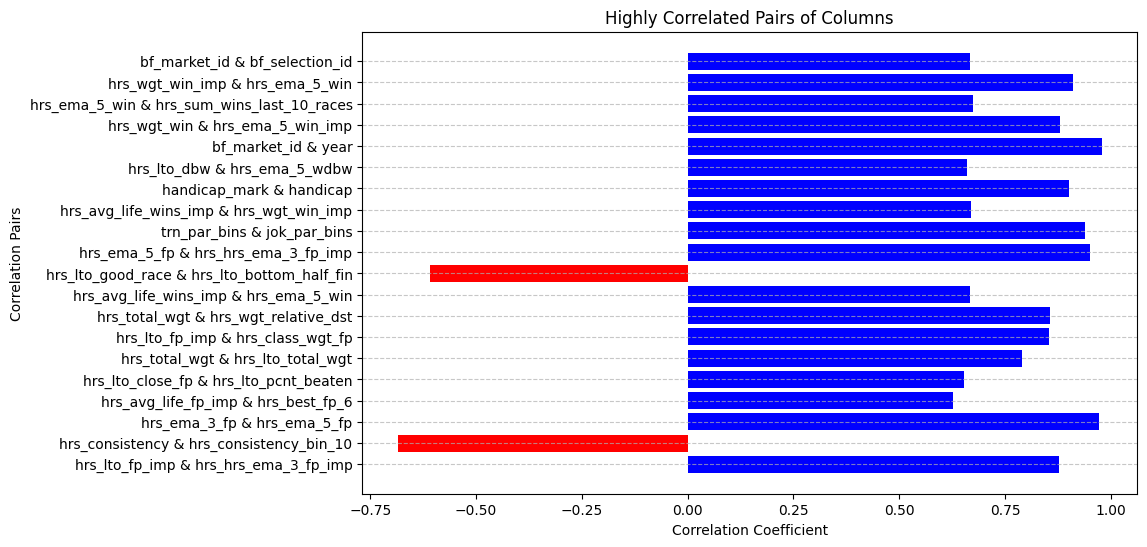

In [ ]:
# Plot pairs of columns with high correlation
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# Identify pairs with high correlation and select any 20 pairs for plotting
import random
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# Randomly select 20 pairs from the high correlation pairs
high_corr_pairs = random.sample(high_corr_pairs, min(20, len(high_corr_pairs)))

# Plot the most highly correlated pairs
plt.figure(figsize=(10, 6))
plt.barh([f"{pair[0]} & {pair[1]}" for pair in high_corr_pairs], [pair[2] for pair in high_corr_pairs], color=['blue' if pair[2] > 0 else 'red' for pair in high_corr_pairs])

plt.ylabel('Correlation Pairs')
plt.xlabel('Correlation Coefficient')
plt.title('Highly Correlated Pairs of Columns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Display the new shape of the dataframe after removing poorly correlated features
print("New DataFrame Shape after Removing Poorly Co-related features:", df.shape)

New DataFrame Shape after Removing Poorly Co-related features: (882983, 124)


#Feature Normalization

In [ ]:
# Feature Normalization
scaler = StandardScaler()

# Identify numerical columns and exclude datetime columns
numerical_cols = df.select_dtypes(include=['number']).columns
datetime_cols = df.select_dtypes(include=['datetime']).columns

# Apply normalization to numerical features only
df_scaled = df.copy()  # Create a copy to preserve the original dataframe
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the new shape of the dataframe after normalization
print("DataFrame Shape after Normalization:", df_scaled.shape)


DataFrame Shape after Normalization: (882983, 124)


#Sorting of the dataset on the basis of meeting date and rece number with Test, Train and Validation split





In [ ]:
# Sort data by 'meeting_date' and 'race_number'
df_sorted = df_original.sort_values(by=['meeting_date', 'race_number'])

# Split the data based on date ranges
train_data = df_sorted[df_sorted['meeting_date'] < '2019-05-01']
val_data = df_sorted[(df_sorted['meeting_date'] >= '2019-05-01') & (df_sorted['meeting_date'] < '2020-05-01')]
test_data = df_sorted[(df_sorted['meeting_date'] >= '2020-05-01') & (df_sorted['meeting_date'] < '2021-05-01')]

# Drop datetime columns from train, validation, and test datasets
datetime_cols = df_sorted.select_dtypes(include=['datetime']).columns
train_data = train_data.drop(columns=datetime_cols, errors='ignore')
val_data = val_data.drop(columns=datetime_cols, errors='ignore')
test_data = test_data.drop(columns=datetime_cols, errors='ignore')

# Drop all non-numeric columns from train, validation, and test datasets
train_data = train_data.select_dtypes(include=['number'])
val_data = val_data.select_dtypes(include=['number'])
test_data = test_data.select_dtypes(include=['number'])

# Define features and target by dropping the target variable column
X_train = train_data.drop(columns=['win'], errors='ignore')
y_train = df_original.loc[train_data.index, 'win']
X_val = val_data.drop(columns=['win'], errors='ignore')
y_val = df_original.loc[val_data.index, 'win']
X_test = test_data.drop(columns=['win'], errors='ignore')
y_test = df_original.loc[test_data.index, 'win']
# Verify that all columns are numeric
print("X_train column types:\n", X_train.dtypes)

X_train column types:
 course_id                                    int64
Unnamed: 0                                   int64
race_number                                  int64
horse_code                                   int64
horse_age                                    int64
                                            ...   
hrs_best_last_10_mordin_speed_rank         float64
hrs_best_all_mordin_speed_rank             float64
hrs_best_all_mordin_speed_going            float64
hrs_best_last_3_mordin_speed_going         float64
hrs_best_last_3_mordin_speed_rank_going    float64
Length: 222, dtype: object


#Decision Tree Model Development


In [ ]:
# Group data by race_id for block-wise processing using original DataFrame
race_groups_train = X_train.groupby(df_original.loc[train_data.index, 'race_id'])
race_groups_val = X_val.groupby(df_original.loc[val_data.index, 'race_id'])
race_groups_test = X_test.groupby(df_original.loc[test_data.index, 'race_id'])

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Training: Iterate over each race block and fit the model
for race_id, race_data in race_groups_train:
    # Extract features and target for the current race block
    race_X = race_data
    race_y = y_train[df_original.loc[train_data.index, 'race_id'] == race_id]

    # Fit the classifier
    clf.fit(race_X, race_y)

# Validation: Iterate over each race block and evaluate the model
val_predictions = []
val_probabilities = []

for race_id, race_data in race_groups_val:
    # Extract features and target for the current race block
    race_X = race_data
    race_y = y_val[df_original.loc[val_data.index, 'race_id'] == race_id]

    # Predict using the classifier
    preds = clf.predict(race_X)
    probs = clf.predict_proba(race_X)[:, 1]

    val_predictions.extend(preds)
    val_probabilities.extend(probs)

# Calculate metrics for validation data
val_accuracy = accuracy_score(df_original.loc[val_data.index, 'win'], val_predictions)
val_f1 = f1_score(df_original.loc[val_data.index, 'win'], val_predictions)
val_precision = precision_score(df_original.loc[val_data.index, 'win'], val_predictions)
val_recall = recall_score(df_original.loc[val_data.index, 'win'], val_predictions)


print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation Classification Report:\n", classification_report(y_val, val_predictions))


# Testing: Iterate over each race block and evaluate the model
test_predictions = []
test_probabilities = []

for race_id, race_data in race_groups_test:
    # Extract features and target for the current race block
    race_X = race_data
    race_y = y_test[df_original.loc[test_data.index, 'race_id'] == race_id]

    # Predict using the classifier
    preds = clf.predict(race_X)
    probs = clf.predict_proba(race_X)[:, 1]

    test_predictions.extend(preds)
    test_probabilities.extend(probs)

# Calculate metrics for test data
test_accuracy = accuracy_score(df_original.loc[test_data.index, 'win'], test_predictions)
test_f1 = f1_score(df_original.loc[test_data.index, 'win'], test_predictions)
test_precision = precision_score(df_original.loc[test_data.index, 'win'], test_predictions)
test_recall = recall_score(df_original.loc[test_data.index, 'win'], test_predictions)


print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test Classification Report:\n", classification_report(y_test, test_predictions))


Validation Accuracy: 0.40255101103785196
Validation F1 Score: 0.17832560841616044
Validation Precision: 0.10409141172134169
Validation Recall: 0.6216977809087707
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.38      0.53     97542
           1       0.10      0.62      0.18     11356

    accuracy                           0.40    108898
   macro avg       0.50      0.50      0.35    108898
weighted avg       0.81      0.40      0.49    108898

Test Accuracy: 0.4140882377286648
Test F1 Score: 0.171806992090607
Test Precision: 0.10005723786420997
Test Recall: 0.6072787427626137
Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.39      0.55    108720
           1       0.10      0.61      0.17     12090

    accuracy                           0.41    120810
   macro avg       0.50      0.50      0.36    120810
weighted avg       0.82      0.41      0